# Training BiLSTM on SNLI using SGD

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/DL_project/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/DL_project
/content/drive/MyDrive/DL_project


In [3]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import *
import os
import time
import gc
import shutil
import h5py

from dfw.dfw import DFW
# ! ls
from dfw.dfw.losses import set_smoothing_enabled
from dfw.dfw.losses import MultiClassHingeLoss
from dfw.experiments.InferSent.data import get_nli, get_batch, build_vocab
from dfw.experiments.InferSent.models import NLINet
from dfw.experiments.reproduce import *

from snli_train_utils import *

In [4]:
GLOVE_PATH = "dfw/experiments/InferSent/dataset/GloVe/glove.840B.300d.txt"
nlipath = 'dfw/experiments/InferSent/dataset/SNLI'
train, valid, test = get_nli(nlipath)
word_vec = build_vocab(train['s1'] + train['s2'] +
                       valid['s1'] + valid['s2'] +
                       test['s1'] + test['s2'], GLOVE_PATH)

for split in ['s1', 's2']:
    for data_type in ['train', 'valid', 'test']:
        eval(data_type)[split] = np.array([['<s>'] +
            [word for word in sent.split() if word in word_vec] +
            ['</s>'] for sent in eval(data_type)[split]])


** TRAIN DATA : Found 549367 pairs of train sentences.
** DEV DATA : Found 9842 pairs of dev sentences.
** TEST DATA : Found 9824 pairs of test sentences.
Found 38957(/43479) words with glove vectors
Vocab size : 38957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
word_emb_dim = 300
config_nli_model = {
    'n_words'        :  len(word_vec)         ,
    'word_emb_dim'   :  word_emb_dim   ,
    'enc_lstm_dim'   :  2048   ,
    'n_enc_layers'   :  1   ,
    'dpout_model'    :  0.    ,
    'dpout_fc'       :  0.       ,
    'fc_dim'         :  512         ,
    'bsize'          :  64     ,
    'n_classes'      :  3      ,
    'pool_type'      :  'max'      ,
    'nonlinear_fc'   :  0   ,
    'encoder_type'   :  'BLSTMEncoder'   ,
    'use_cuda'       :  True                  ,

}

In [ ]:
trainer = Net_Trainer(device, 'blstm_sgd_snli', config_nli_model, word_vec, train, valid, test, lr=0.1, optm='sgd', loss='svm', batch_size=64, epochs=100, 
                          lr_decay=0.99, lr_shrink=5.0, weight_decay=0, mom=0, smooth=False)
best_epoch, losses, errors, accs, testacc = trainer.train()
plot_train(losses, errors, accs)
print('Best epoch:',best_epoch)
print('Test accuracy:',testacc,'%')

cuda Tesla T4
Epoch:0   Loss:0.513   Val loss:1.069   Accuracy:50.125   Best val loss:1.069   Time taken:322.29
Epoch:1   Loss:0.068   Val loss:1.164   Accuracy:48.719   Best val loss:1.069   Time taken:323.287
Epoch:2   Loss:0.076   Val loss:0.973   Accuracy:58.031   Best val loss:0.973   Time taken:319.243
Epoch:3   Loss:0.059   Val loss:1.003   Accuracy:57.375   Best val loss:0.973   Time taken:322.233
Epoch:4   Loss:0.194   Val loss:0.971   Accuracy:57.359   Best val loss:0.971   Time taken:321.571
Epoch:5   Loss:0.14   Val loss:0.952   Accuracy:55.984   Best val loss:0.952   Time taken:322.421
Epoch:6   Loss:0.134   Val loss:0.825   Accuracy:63.219   Best val loss:0.825   Time taken:326.248
Epoch:7   Loss:0.124   Val loss:0.784   Accuracy:63.688   Best val loss:0.784   Time taken:321.03
Epoch:8   Loss:0.112   Val loss:0.821   Accuracy:61.312   Best val loss:0.784   Time taken:325.414
Epoch:9   Loss:0.382   Val loss:0.777   Accuracy:63.969   Best val loss:0.777   Time taken:321.306

cuda Tesla K80


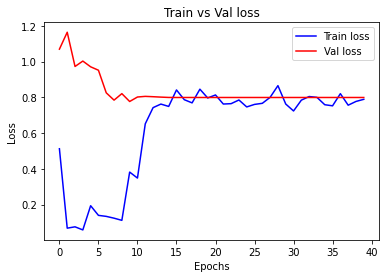

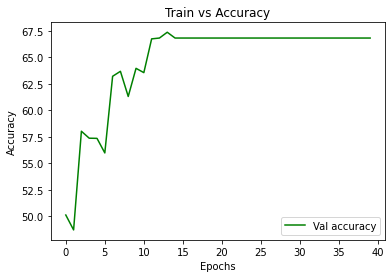

Best epoch: 9
Test accuracy: 61.109375 %


In [7]:
# Conitnue training by loading checkpoint
# Best epoch = epoch with least val loss
# This cell is used only for plotting graph
trainer = Net_Trainer(device, 'blstm_sgd_snli', config_nli_model, word_vec, train, valid, test, load_ckpt='v1_ckpt_blstm_sgd_snli', lr=0.1, optm='sgd', loss='svm', 
                      batch_size=64, epochs=40, lr_decay=0.99, lr_shrink=5.0, weight_decay=0, mom=0, smooth=False)
best_epoch, losses, errors, accs, testacc = trainer.train()
plot_train(losses, errors, accs)
print('Best epoch:',best_epoch)
print('Test accuracy:',testacc,'%')

In [6]:
best_acc = test_model(device, config_nli_model, 'v1_ckpt_blstm_sgd_snli_best', test, 64, word_vec)
print('Test accuracy of best model:',best_acc)

Test accuracy of best model: 61.953125
